In [3]:
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


## Install Required Libraries 

In [4]:
from IPython.display import Image
from pprint import pprint
import torch
import rich
import random

## Import Required Libraries 

In [5]:
from haystack import Pipeline, Document
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.writers.document_writer import DuplicatePolicy
from elasticsearch_haystack.document_store import ElasticsearchDocumentStore
from elasticsearch_haystack.embedding_retriever import ElasticsearchEmbeddingRetriever
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.builders import PromptBuilder

/home/viit/viitproject/omkar/miniconda3/envs/hs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Document Store Initialization 

In [6]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")
print(document_store.count_documents())

711


## Document Preprocessing Pipeline:

In [5]:
preprocessing_pipeline = Pipeline()

preprocessing_pipeline.add_component("converter", PyPDFToDocument())
preprocessing_pipeline.add_component("cleaner", DocumentCleaner())
preprocessing_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=400))
preprocessing_pipeline.add_component("doc_embedder", SentenceTransformersDocumentEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0",))
preprocessing_pipeline.add_component("writer", DocumentWriter(document_store=document_store,policy=DuplicatePolicy.OVERWRITE))

preprocessing_pipeline.connect("converter", "cleaner")
preprocessing_pipeline.connect("cleaner", "splitter")
preprocessing_pipeline.connect("splitter", "doc_embedder")
preprocessing_pipeline.connect("doc_embedder", "writer")

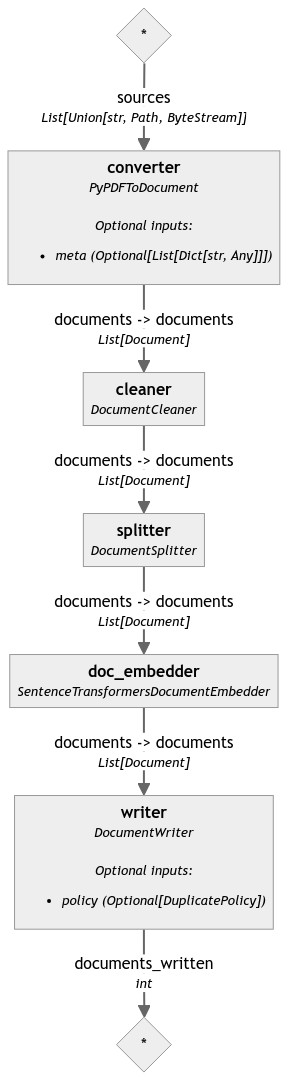

In [6]:
preprocessing_pipeline.draw("preprocessing_pipeline.png")
Image(filename='preprocessing_pipeline.png')

## Document Loading

In [7]:
import os
from pathlib import Path
file_paths = ["data" / Path(name) for name in os.listdir("data")]

In [8]:
file_paths

[PosixPath('data/GFR2017.pdf'),
 PosixPath('data/DPM2009.pdf'),
 PosixPath('data/The Stages of Tendering are as Follows.pdf'),
 PosixPath('data/DFPDS21.pdf')]

In [9]:
preprocessing_pipeline.run({"converter": {"sources": file_paths}})

Batches: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


{'writer': {'documents_written': 620}}

## Checking documents stored in VectorDB

In [7]:
len(document_store.filter_documents())

711

In [9]:
pprint(document_store.filter_documents()[130])

Document(id=79eb87ce8c307e8f62dc2a8f926e12e60cfbba97d219ce3e6ce65b3274ea295d, content: 'equipment; (iv) counter guarantees to banks in consideration of the banks having issued letters of c...', meta: {'file_path': 'data/GFR2017.pdf', 'source_id': 'c08af0778007678c517d7a728e565fd1040b48b335aab4429bfc006f896a075a'}, score: 1.0, embedding: vector of size 1024)


In [14]:
print(document_store.filter_documents()[130].meta) # meta data

{'file_path': 'data/GFR2017.pdf', 'source_id': 'c08af0778007678c517d7a728e565fd1040b48b335aab4429bfc006f896a075a'}


In [10]:
print(len(document_store.filter_documents()[130].embedding)) # embedding size

1024


## Initialize Generator

In [15]:
generator = HuggingFaceLocalGenerator("mistralai/Mistral-7B-Instruct-v0.1",
                                 huggingface_pipeline_kwargs={"device_map":"auto",
                                               "model_kwargs":{"load_in_4bit":True,
                                                "bnb_4bit_use_double_quant":True,
                                                "bnb_4bit_quant_type":"nf4",
                                                "bnb_4bit_compute_dtype":torch.bfloat16}},
                                 generation_kwargs={"max_new_tokens": 800})

In [16]:
generator.warm_up()

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


In [19]:
# quick check for generator 
rich.print(generator.run("Please write a poem about my country"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{
    'replies': [
        '.\n\nI am a poet, I am a writer,\nI am a citizen of this great nation,\nI am a patriot, I am a lover,\nI 
am a poet, I am a writer.\n\nMy country is a beautiful land,\nWith mountains, rivers, and beaches,\nA land of 
freedom, a land of grand,\nA land of opportunities, a land of peace.\n\nMy country is a land of diversity,\nWith 
people from all walks of life,\nA land of unity, a land of liberty,\nA land of hope, a land of love.\n\nMy country 
is a land of progress,\nWith a rich history and a bright future,\nA land of innovation, a land of success,\nA land 
of dreams, a land of opportunity.\n\nMy country is a land of courage,\nWith brave men and women who fight for 
justice,\nA land of resilience, a land of strength,\nA land of hope, a land of peace.\n\nMy country is a land of 
freedom,\nWith a constitution that protects our rights,\nA land of justice, a land of equality,\nA land of freedom,
a land of peace.\n\nMy country is a land of opportunity,\nWith a thriving economy and a strong job market,\nA land 
of innovation, a land of progress,\nA land of opportunity, a land of prosperity.\n\nMy country is a land of 
beauty,\nWith a rich culture and a vibrant arts scene,\nA land of music, a land of dance,\nA land of beauty, a land
of peace.\n\nMy country is a land of unity,\nWith a shared vision and a common goal,\nA land of hope, a land of 
peace,\nA land of unity, a land of love.\n\nMy country is a land of freedom,\nWith a constitution that protects our
rights,\nA land of justice, a land of equality,\nA land of freedom, a land of peace.\n\nMy country is a land of 
opportunity,\nWith a thriving economy and a strong job market,\nA land of innovation, a land of progress,\nA land 
of opportunity, a land of prosperity.\n\nMy country is a land of beauty,\nWith a rich culture and a vibrant arts 
scene,\nA land of music, a land of dance,\nA land of beauty, a land of peace.\n\nMy country is a land of 
unity,\nWith a shared vision and a common goal,\nA land of hope, a land of peace,\nA land of unity, a land of 
love.\n\nMy country is a land of freedom,\nWith a constitution that protects our rights,\nA land of justice, a land
of equality,\nA land of freedom, a land of peace.\n\nMy country is a land of opportunity,\nWith a thriving economy 
and a strong job market,\nA land of innovation, a land of progress,\nA land of opportunity, a land of 
prosperity.\n\nMy country is a land of beauty,\nWith a rich culture and a vibrant arts scene,\nA land of music, a 
land of dance,\nA land of beauty, a land of peace.\n\nMy country is a land of unity,\nWith a shared vision and a 
common goal,\nA land of hope, a land of peace,\nA land of unity, a land of love.\n\nMy country is a land of 
freedom,\nWith a constitution that protects our rights,\nA land of justice, a land of equality,\nA land of freedom,
a land of peace.\n\nMy country is a land of opportunity,\nWith a thriving economy and a strong job market,\nA'
    ]
}

## Prompt Template and Builder: 

In [21]:

prompt_template = """<|system|> Using the information contained in the context, give a comprehensive answer to the question.
If the answer is contained in the context, also report the source data.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  {% for doc in documents %}
  {{ doc.content }} 
  {% endfor %};
  \nQuestion: {{query}}
  \nAnswer:
  </s>
  
Example:
\nQuestion:What are the documents and stages for undertaking an open tender enquiry under DFPDS schedule 19.3?
\nAnswer: 1. In Principal Approval (IPA):
   - What happens: Getting the initial approval to proceed with the procurement.
   - Documents involved: Explanation of the project, what needs to be done, how much it will cost, and any financial support needed.
   - Key point: This approval comes from the Central Financial Assistance (CFA) after proper discussions.

2. Acceptance of Necessity (AoN):
   - What happens: Confirming that there's a genuine need for the procurement and estimating the costs.
   - Documents involved: Cost estimates, comparisons with previous purchases, and making sure the plan is clear.
   - Key point: The CFA approves this, considering suggestions from the Independent Financial Advisor (IFA) if needed.

3. Upload Bid on GeM:
   - What happens: Putting the details of the procurement online, especially on the Government e-Marketplace (GeM).
   - Key point: Timing depends on the type of procurement.

4. Technical Evaluation Committee (TEC):
   - What happens: Checking if the bidders meet the technical requirements.
   - Documents involved: Scrutinizing documents submitted by bidders and ensuring they meet the specified criteria.
   - Key point: Non-compliant bidders get a chance to fix issues within 48 hours.

5. Benchmarking:
   - What happens: Comparing the estimated costs with market prices to ensure fairness.
   - Documents involved: Checking how prices compare to what was estimated.
   - Key point: Prices are set a bit higher than the initial estimates.

6. Commercial Opening of Bid (COB):
   - What happens: Opening bids to see the prices submitted by compliant bidders.
   - Key point: Analysis of prices helps decide if negotiation is needed with the top bidder. Reverse auction may happen if multiple bidders qualify.

7. Cost Negotiation Committee (CNC)/Price Negotiation Committee (PNC):
   - What happens: Checking if the costs can be negotiated and if it aligns with guidelines.
   - Key point: Negotiations are done, and financial details are recommended for approval. All this is reviewed by the CFA.

8. Expenditure Angle Sanction (EAS):
   - What happens: Getting the final approval for the expenses from the CFA.
   - Key point: This is the green light to go ahead with the procurement.

9. Supply Order:
   - What happens: Placing the order with the chosen bidder.
   - Key point: The procurement process is complete, and the chosen bidder is officially hired to do the job.

<|assistant|>
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [1]:
# rag = Pipeline()
# rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
# rag.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k=3))
# rag.add_component("prompt_builder", prompt_builder)
# rag.add_component("llm", generator)

# rag.connect("text_embedder", "retriever")
# rag.connect("retriever.documents", "prompt_builder.documents")
# rag.connect("prompt_builder.prompt", "llm.prompt")

# rag.draw("rag.png")
# Image(filename='rag.png')

In [2]:
# def get_generative_answer(query):

#   results = rag.run({
#       "text_embedder": {"text": query},
#       "prompt_builder": {"query": query}
#     }
#   )

#   answer = results["llm"]["replies"][0]
#   rich.print(answer)
  
#   print(get_generative_answer("what is Re-tendering from DPM document?"))

## Document Retrieval and Answer Generation (RAG) Pipelines 
 

In [22]:

# Create RAG pipeline
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
rag_pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.connect("text_embedder", "retriever")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "llm.prompt")

# Create document retrieval pipeline
doc_retrieval_pipeline = Pipeline()
doc_retrieval_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
doc_retrieval_pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k=3))
doc_retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")



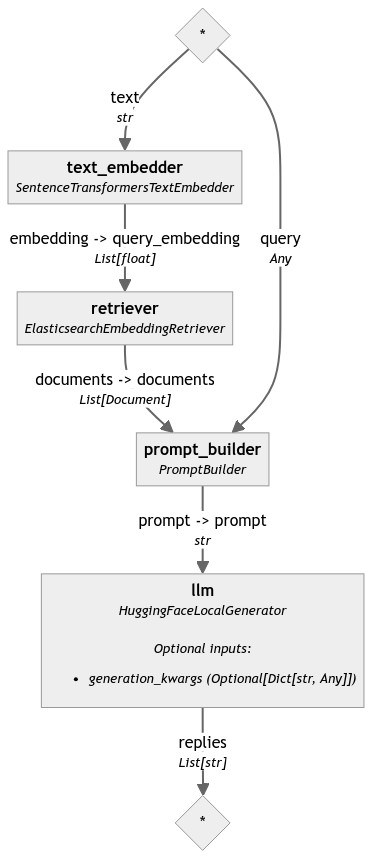

In [23]:
rag_pipeline.draw("rag_pipeline.png")
Image(filename='rag_pipeline.png')

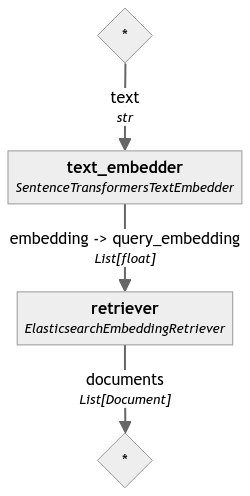

In [24]:
doc_retrieval_pipeline.draw("doc_retrieval_pipeline.png")
Image(filename='doc_retrieval_pipeline.png')

## Function to Get Answer with Relevant Documents 

In [25]:
def get_answer_with_relevant_docs(query, rag_pipeline, query_pipeline):
    # Use the query pipeline to retrieve relevant documents
    relevant_docs = query_pipeline.run({"text_embedder": {"text": query}})['retriever']['documents']

    # Extract relevant document IDs and page numbers
    relevant_doc_info = [(doc.id,doc.meta.get("file_path"), doc.meta.get("page_number", "N/A"),doc.content) for doc in relevant_docs]
    #relevant_doc_paths = [doc.meta.get("file_path") for doc in relevant_docs]
    # Use the RAG pipeline to generate an answer
    results = rag_pipeline.run({
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query}
    })

    # Extract the generated answer
    answer = results["llm"]["replies"][0]

    return answer, relevant_doc_info

## Example Usage

In [28]:
# Enter Your question here:
query = "What is full form of GFR document with its scope?"
answer, relevant_doc_info = get_answer_with_relevant_docs(query, rag_pipeline, doc_retrieval_pipeline)

# Print the answer
print('Answer:')
rich.print(answer)

# Print relevant documents with page numbers
print('Relevant Documents:')
for doc_id, doc_path,page_number,doc_content in relevant_doc_info:
    print(f"Document ID: {doc_id}\t,Document Path: {doc_path}\t, Page Number: {page_number}")
    print("-------------------------------------------------------------------------------")
    print(f"Document Content:\n{doc_content}")
    print("========================== End oF Document=====================================\n")

Batches: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Answer:


Answer:

The full form of GFR document is General Financial Rules. Its scope includes providing a framework within which an 
organization manages its business in a financially prudent manner without compromising its flexibility to deal with
varied situations. The GFRs cover various aspects such as budgeting, accounting, procurement, inventory management,
contract management, grants-in-aid, loans, government guarantees, and miscellaneous subjects. The rules are 
designed to promote simplicity and transparency in the Government financial system and procedures.

Relevant Documents:
Document ID: 415be40fb8b891703ecf3d271c29e736b27199539dbdd861657c2ac6ae1bc21e	,Document Path: data/GFR2017.pdf	, Page Number: N/A
-------------------------------------------------------------------------------
Document Content:
specific requirements of their domain. Detailed deliberations were also carried out within the Ministry. C&AG’s comments on the draft GFRs have also been taken into consideration.
6. The aim of any rule is to provide a framework within which an organization manages its business in a financially prudent manner without compromising its flexibility to deal with varied situations. The GFRs 2005 have been very comprehensively reviewed with the aim of promoting simplicity and transparency in the Government financial system and procedures. It is expected that the new GFRs 2017 will enable an improved, efficient and effective framework of fiscal management while providing the necessary flexibility to facilitate timely delivery of services.
7. Departm